### Import the API

Run the following cell to import the API into your session.

In [ ]:
import ee
import geemap

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=tgEYkELMLvku2kg_5wwIqvT0tmypR2P5LVlnSRsSWV8&tc=RHlp8Ii3B9oPX6DO5Fj5acglGbmAo2mRIoQnk2rbH7s&cc=IXsfJVTfqfB_FiUgf4-i8cVXX4m0LFjSgBk4-bmuLSA

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VMSqavFXKxfHfYUEpWSJOJ_bc02VeQ-1EhjE14t0-mY37ipRsrvSDk

Successfully saved authorization token.


## Test the API

Test the API by printing the elevation of Mount Everest.

In [ ]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


## Chart visualization - Bare Soil Band


Some Earth Engine functions produce tabular data that can be plotted by
data visualization packages such as `matplotlib`. The following example
demonstrates the display of tabular data from Earth Engine as a scatter
plot. See [Charting in Colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)
for more information.

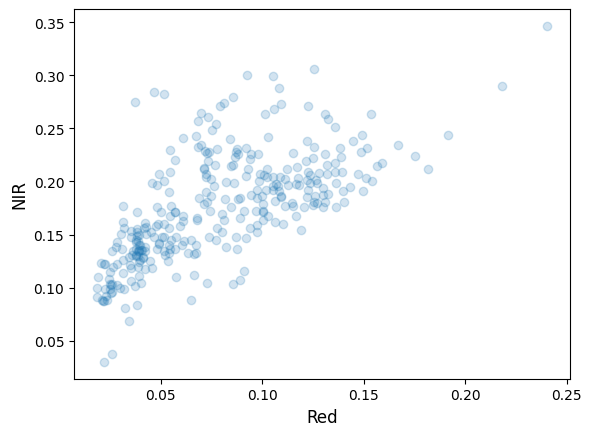

In [ ]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

# Precipitation Analysis via Remote Sensing


In [ ]:
%pip install merge-downloader


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ecCodes: filename=eccodes-1.3.1-py3-none-any.whl size=39036 sha256=00ae4fdf3521ce9ebb087423e0c61c112aa8d9c52fa96dbe7569d00ef58924e3
  Stored in directory: /root/.cache/pip/wheels/2b/20/49/9979619aae36b997b5ac102b0c938558f6e0aaad2ac128a150
  Created wheel for findlibs: filename=findlibs-0.0.5-py3-none-any.whl size=6944 sha256=54ebd14c8fe2721a7d017a8de111d3841910fb62bc2fccef087e39b646a67f00
  Stored in directory: /root/.cache/pip/wheels/2e/67/14/22fa5b9fd9c41be520b37e908597d6a262803c0fcf2ba7c2

In [ ]:
from mergedownloader.inpeparser import INPETypes

INPETypes.types()

In [ ]:
from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import INPETypes, INPEParsers
from mergedownloader.utils import GISUtil
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# create a temporary folder to store the files
!mkdir ./tmp

downloader = Downloader(
    server=INPEParsers.FTPurl,
    parsers=INPEParsers.parsers,
    local_folder='./tmp'
)

In [ ]:
# open the countries dataset
path="/content/drive/MyDrive/SHAPES REFERENCIA/COLOMBIA/COL_AdminBoundaries_candidate.gdb"
col_dptboundaries=gpd.read_file(path, driver='FileGDB', layer='col_admbnda_adm1_mgn_20200416')
dptos=['Casanare','Meta','Arauca','Vichada']
dpto_interest=col_dptboundaries[col_dptboundaries['admin1Name_es'].isin(dptos)]


In [ ]:
# create a cube for the first half of June
cube = downloader.create_cube(
    start_date='2010-01',
    end_date='2011-02',
    datatype=INPETypes.YEARLY_ACCUM
)

# cut the cube by the given geometry
llanosorientales_cube = GISUtil.cut_cube_by_geoms(
    cube=cube,
    geometries =dpto_interest.geometry
)
# accumulate the rain along the time axis
roi_rain = llanosorientales_cube.sum(dim='time', skipna=False)

# plot the figure
fig, ax = plt.subplots(figsize=(8, 5))
roi_rain.plot(ax=ax)
col_dptboundaries.plot(ax=ax, facecolor='none', edgecolor='firebrick')

## Date Time Series from datacubes


In [ ]:
# Create big cube
cube_1980_2022= downloader.create_cube(
    start_date='2001-01',
    end_date='2022-12',
    datatype=INPETypes.MONTHLY_ACCUM_YEARLY
)
# Create the series, mean as the aggregation stats
series_allyears = downloader.get_time_series(
    cube=cube_1980_2022,
    shp=dpto_interest.geometry,
    reducer=xr.DataArray.mean
)

series_allyears



ConnectionError: ignored

In [ ]:
# Aquí se exportó la serie de tiempo con los valores medios de la serie de tiempo en el ROI del 2001 hasta el 2022
## No hay valores en el año 2000 ya que este año no se encuentra disponible.
series_allyears.to_csv('Rainfall_Monthly_2001to2022_INPEMerge.csv')


In [ ]:
%load_ext autoreload
%autoreload 2

from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import INPEParsers, INPETypes

downloader = Downloader(
    server=INPEParsers.FTPurl,
    parsers=INPEParsers.parsers,
    local_folder='/content/drive/MyDrive/UofG/MERGEDATA'

)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
files_2001_2022 = downloader.get_range(
    start_date='20030101',
    end_date='20221231',
    datatype=INPETypes.MONTHLY_ACCUM_YEARLY,
    force_download=False
)

# assert files exist
for file in files_2001_2022:
    assert file.exists()

# list the files
files_2001_2022

ConnectionError: ignored